In [127]:
import pickle
import warnings
import umap
import random
import torch

import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from collections import OrderedDict, Counter, defaultdict
from sklearn import decomposition
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from itertools import chain

from torch.nn import functional as F

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [5]:
warnings.simplefilter('ignore')
alt.data_transformers.enable('default', max_rows=None)
pd.options.display.max_rows = 200

In [6]:
embeds, rows = [], []

for path in tqdm(glob('../data/embeds-en/*.p')):
    with open(path, 'rb') as fh:
        
        lines = pickle.load(fh)

        for line in lines:
            title = ' '.join(line.pop('tokens'))
            embeds.append(line.pop('embedding'))
            rows.append(OrderedDict(title=title, **line))

100%|██████████| 65/65 [00:23<00:00,  3.29it/s]


In [7]:
embeds = np.stack(embeds)

In [8]:
df = pd.DataFrame(rows)

In [9]:
domains = df.label.unique()

In [10]:
domains

array(['apnews.com', 'washingtonpost.com', 'breitbart.com',
       'dailykos.com', 'nytimes.com', 'foxnews.com', 'bloomberg.com',
       'cnn.com', 'huffingtonpost.com', 'wsj.com', 'buzzfeed.com',
       'dailycaller.com', 'thehill.com'], dtype=object)

In [11]:
embeds.shape

(642237, 512)

In [82]:
dr = decomposition.TruncatedSVD(10)
embedding = dr.fit_transform(embeds[df.index])

In [83]:
dr.explained_variance_ratio_

array([0.23581453, 0.17579766, 0.10987362, 0.09071743, 0.08797473,
       0.07329033, 0.04791307, 0.04447076, 0.03889624, 0.03226224],
      dtype=float32)

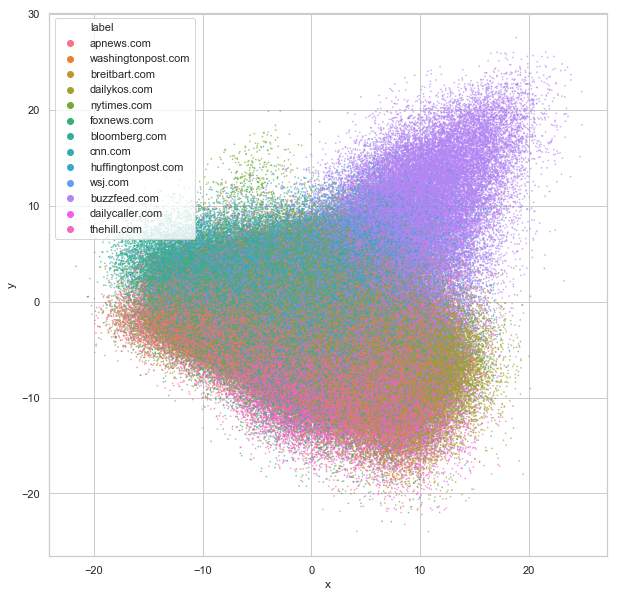

In [84]:
points = df.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

plt.figure(figsize=(10,10))

sns.scatterplot(
    x='x',
    y='y',
    data=points,
    s=1,
    edgecolor=None,
    alpha=0.5,
    hue='label',
)

In [33]:
pdf = df.sample(frac=0.1)
dr = umap.UMAP(metric='cosine', verbose=True)
embedding = dr.fit_transform(embeds[pdf.index])

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='cosine',
   metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Construct embedding
	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


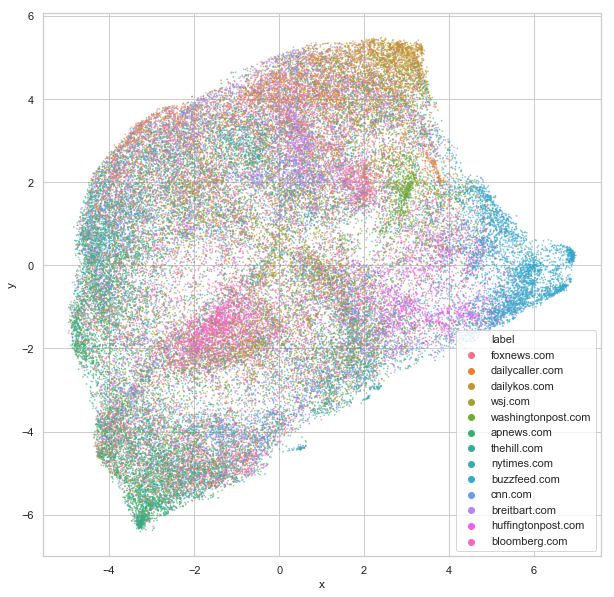

In [38]:
points = pdf.copy()
points['x'] = embedding[:,0]
points['y'] = embedding[:,1]

plt.figure(figsize=(10,10))

sns.scatterplot(
    x='x',
    y='y',
    data=points,
    s=1,
    edgecolor=None,
    alpha=0.5,
    hue='label',
)

apnews.com


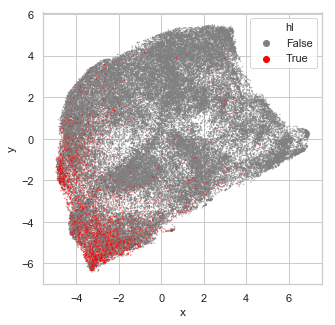

washingtonpost.com


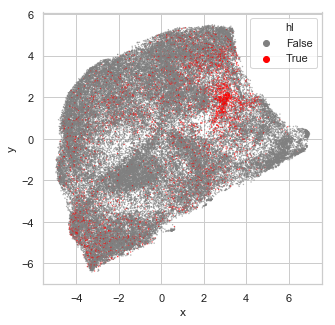

breitbart.com


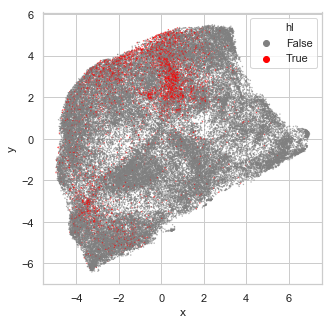

dailykos.com


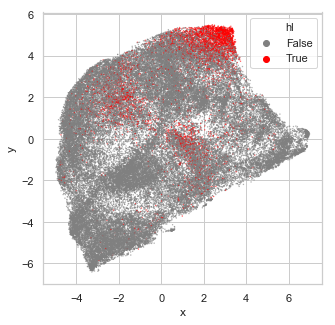

nytimes.com


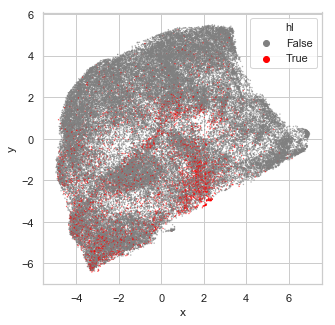

foxnews.com


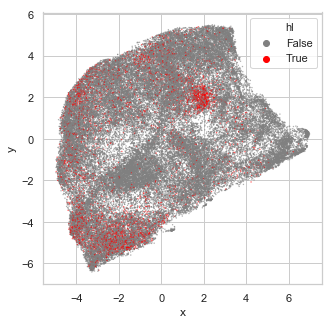

bloomberg.com


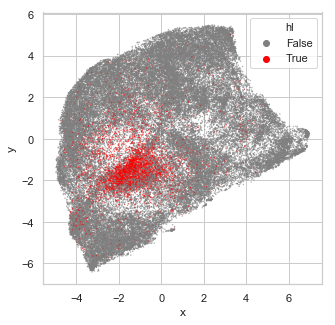

cnn.com


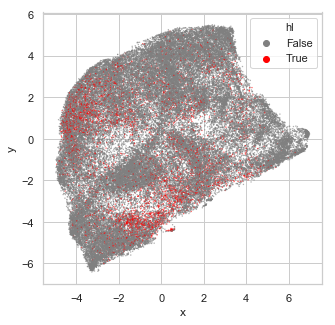

huffingtonpost.com


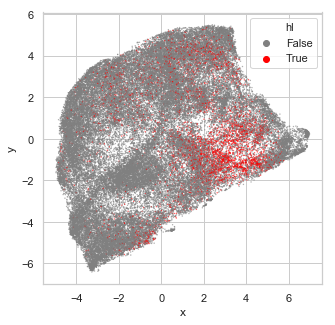

wsj.com


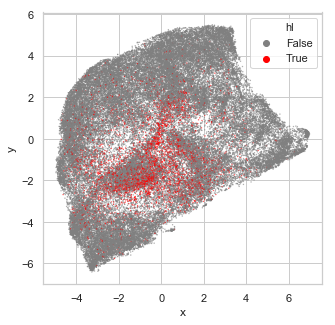

buzzfeed.com


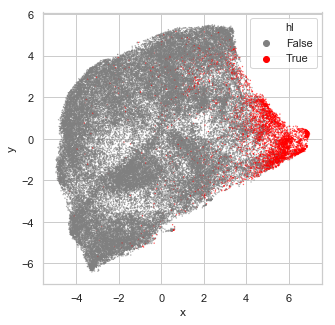

dailycaller.com


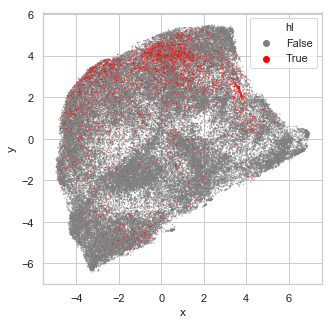

thehill.com


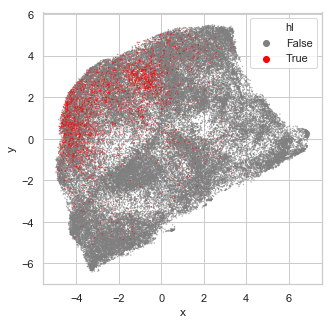

In [46]:
for domain in df.label.unique():

    plt.figure(figsize=(5,5))

    points['hl'] = points.label.apply(lambda d: d==domain)

    print(domain)
    
    sns.scatterplot(
        x='x',
        y='y',
        data=points,
        s=0.5,
        edgecolor=None,
        alpha=0.5,
        hue='hl',
        palette={True: 'red', False: 'gray'}
    )
    
    plt.show()

In [12]:
def sampled_pw_ds(d, n=1000000):
    
    d_embeds = embeds[df[df.label==d].index]
    
    idx1 = np.random.choice(range(len(d_embeds)), n)
    idx2 = np.random.choice(range(len(d_embeds)), n)
    
    x1 = torch.from_numpy(d_embeds[idx1])
    x2 = torch.from_numpy(d_embeds[idx2])
    
    ds = F.cosine_similarity(x1, x2)
    
    return -(ds.numpy() - 1)

In [13]:
ds = {
    d: sampled_pw_ds(d)
    for d in tqdm(domains)
}

100%|██████████| 13/13 [01:20<00:00,  5.49s/it]


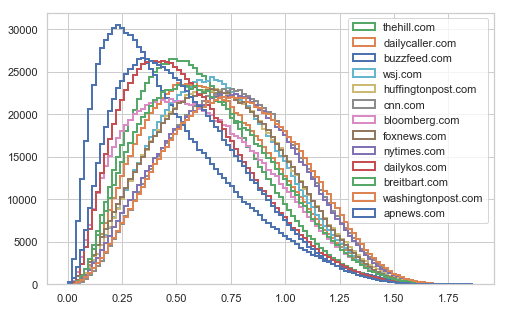

In [26]:
plt.figure(figsize=(8,5))
ys, x, _ = plt.hist(ds.values(), histtype='step', bins=100, linewidth=2, label=ds.keys())
plt.legend(loc='upper right')

In [27]:
rows = []
for y, domain in zip(ys, ds.keys()):
    for d, count in zip(x[:-1], y):
        rows.append((domain, d, count))
    
hist_df = pd.DataFrame(rows, columns=('domain', 'd', 'count'))

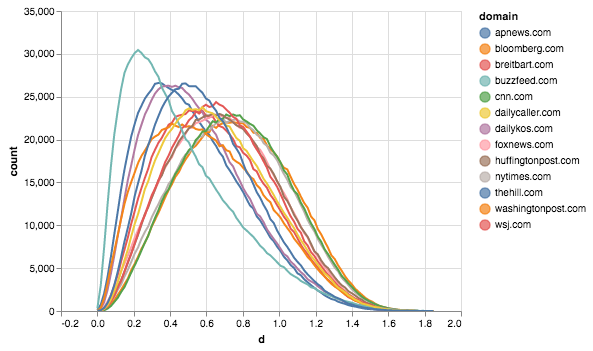

In [28]:
highlight = alt.selection(
    type='single',
    on='mouseover',
    fields=['domain'],
    nearest=True,
)

base = (alt
    .Chart(hist_df, width=400, height=300)
    .encode(x='d', y='count', color='domain'))

points = (base
    .mark_circle()
    .encode(opacity=alt.value(0))
    .add_selection(highlight))

line_size = alt.condition(~highlight, alt.value(2), alt.value(5))

lines = (base
    .mark_line()
    .encode(size=line_size, tooltip='domain'))

points + lines

In [93]:
rows = [(domain, d) for domain, dds in ds.items() for d in dds]
ds_df = pd.DataFrame(rows, columns=('domain', 'd'))

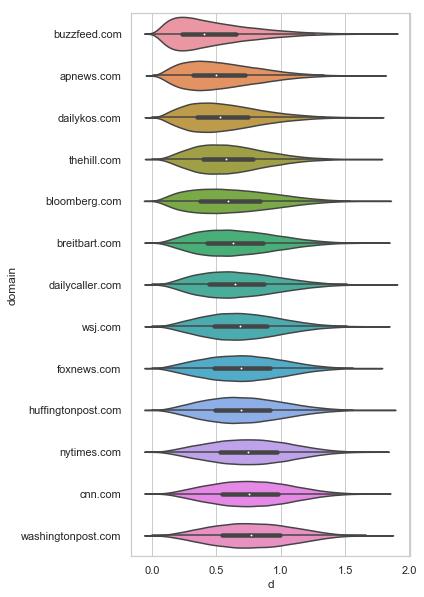

In [94]:
order = ds_df.groupby('domain').mean().sort_values('d').index
plt.figure(figsize=(5,10))
sns.violinplot(y='domain', x='d', data=ds_df.sample(frac=0.1), order=order)

In [95]:
def mode_kde(ds, bins=100):
    x = np.linspace(-1, 1, bins)
    kde_density = stats.kde.gaussian_kde(ds)
    y_nparam = kde_density(x)
    return x[np.argsort(y_nparam)[-1]]

In [88]:
pwd_mode = mode_kde(np.concatenate(list(ds.values())))

In [167]:
def plot_cluster(d):
    
    d_embeds = embeds[df[df.label==d].index]
    z = linkage(d_embeds[:2000], metric='cosine', method='average')
    
    plt.figure(figsize=(10,5))
    plt.ylim(0, 1)
    
    _ = dendrogram(z, color_threshold=pwd_mode, no_labels=True, count_sort='descending')
    plt.show()
    
    clusters = fcluster(z, pwd_mode, criterion='distance')
    counts = Counter(clusters).most_common()
    
    print([c for _, c in counts[:10]])

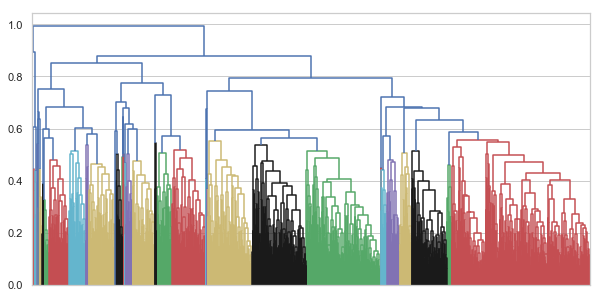

[496, 266, 193, 160, 125, 121, 95, 81, 72, 60]


In [168]:
plot_cluster('cnn.com')

buzzfeed.com


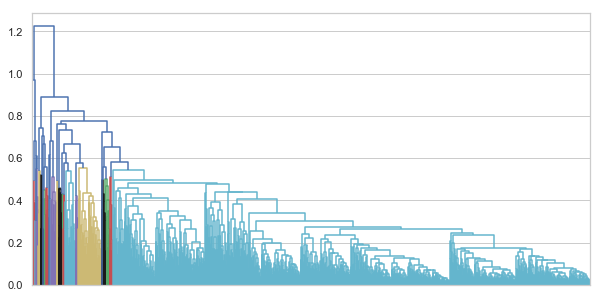

[1710, 83, 37, 20, 17, 13, 11, 11, 11, 11]
apnews.com


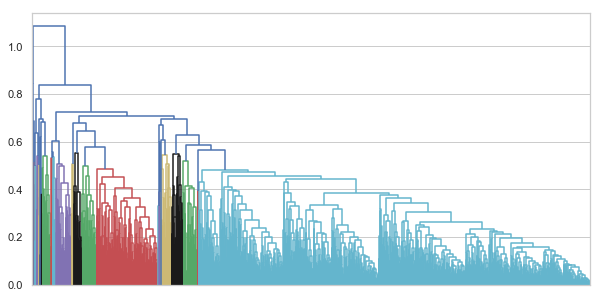

[1403, 222, 56, 54, 53, 39, 38, 35, 27, 13]
dailykos.com


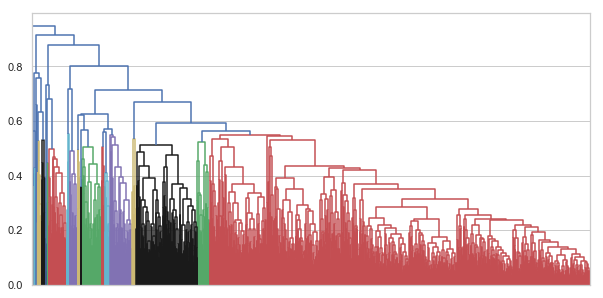

[1363, 218, 78, 71, 66, 46, 28, 19, 17, 15]
thehill.com


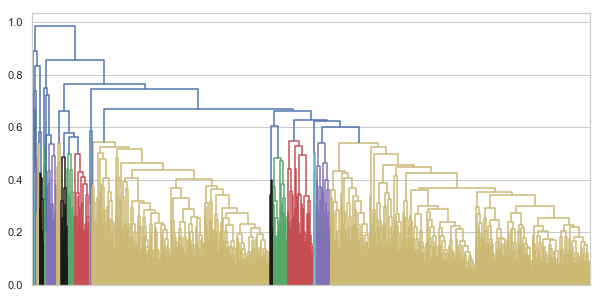

[930, 638, 93, 54, 54, 51, 36, 28, 21, 15]
bloomberg.com


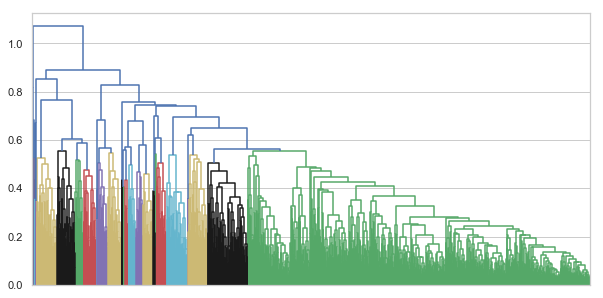

[1228, 142, 75, 74, 71, 63, 48, 46, 39, 38]
breitbart.com


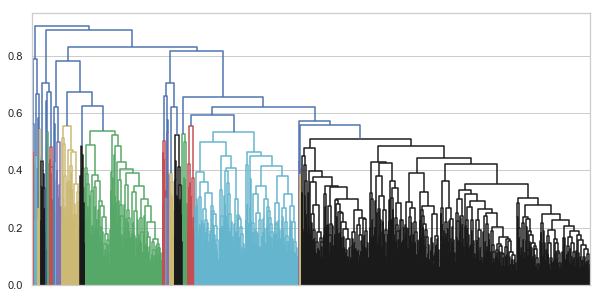

[1034, 370, 281, 65, 27, 25, 21, 20, 19, 18]
dailycaller.com


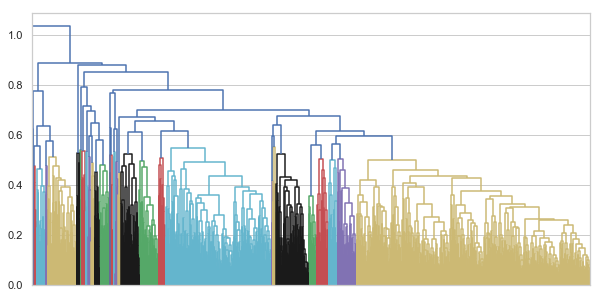

[836, 381, 115, 104, 70, 69, 64, 43, 38, 32]
wsj.com


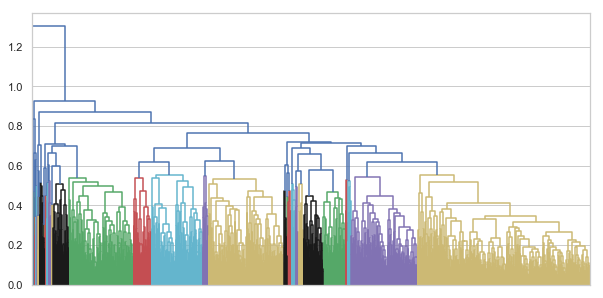

[617, 270, 240, 233, 184, 83, 68, 65, 55, 21]
foxnews.com


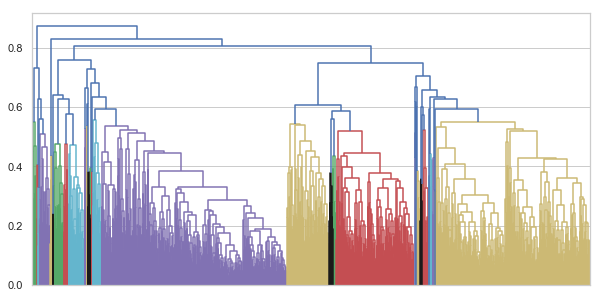

[665, 555, 280, 151, 57, 39, 37, 32, 23, 18]
huffingtonpost.com


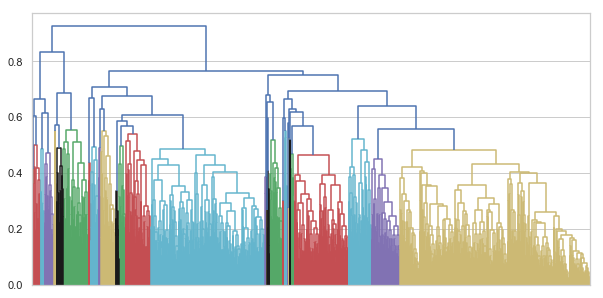

[681, 408, 194, 103, 92, 92, 82, 53, 47, 34]
nytimes.com


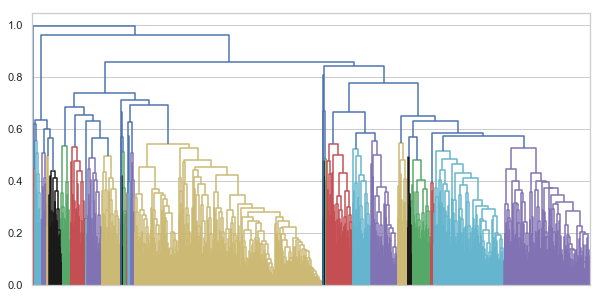

[673, 308, 252, 96, 94, 71, 66, 66, 53, 53]
cnn.com


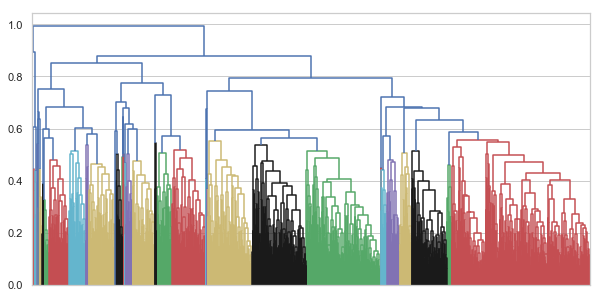

[496, 266, 193, 160, 125, 121, 95, 81, 72, 60]
washingtonpost.com


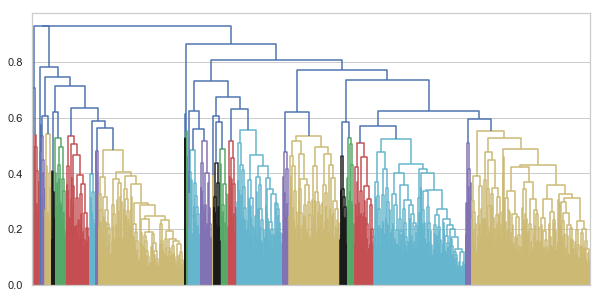

[425, 329, 307, 183, 164, 83, 69, 44, 43, 41]


In [145]:
for d in order:
    print(d)
    plot_cluster(d)